In [1]:
# import 

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime

from dateutil.relativedelta import relativedelta
import glob
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy    as np
#import networkx as nx
from operator import itemgetter
import pandas   as pd
import rdflib as rdflib
import re
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import sys
from rdflib.namespace import XSD, Namespace
from rdflib.term import URIRef

import IPython
import pprint
pp = pprint.PrettyPrinter(indent=4)



from constants import *
from helpers import *

# colors
import matplotlib.colors as mcolors
from matplotlib import cm
# set style
import seaborn as sns

#set_theme() 
sns.set_theme(style="white",palette="PuOr_r")

In [2]:
from rdflib import Graph

f = Graph() #/u/98/peurat1/unix/Desktop/kirjasampo/data/graph2.ttl
#f.parse(data="../../data/finnish_graph2.nt", format="nt")

f.parse('../../data/finnish_graph_new.nt')

# foreign
g = Graph() #/u/98/peurat1/unix/Desktop/kirjasampo/data/graph2.ttl
#f.parse(data="../../data/finnish_graph2.nt", format="nt")

g.parse('../../data/nat_lang_graph2.nt')

<Graph identifier=Na106ddc8a2ed439d9f7ce3b05a7b70bb (<class 'rdflib.graph.Graph'>)>

In [3]:
# genre

genre=pd.read_csv("../../data/genre_df.csv", sep="\t", index_col=0)
genre_dict={}
for i,v in genre.groupby("genrename").apply(lambda x: list(x["genre"])).iteritems():
   # print(i,v)
    #genre_dict[i]=" ".join(["<"+uri+">" for uri in v])
    genre_dict[i] =v

    
# cluster per genre information
# load genre graphs
g_fi = Graph() 
g_fi.parse("../../data/finnish_genre_theme.nt",format="nt")

g_fo = Graph() 
g_fo.parse("../data/translated_theme_genre_new.nt",format="nt")

<Graph identifier=N49f69a04a4e1406993355e9789517b61 (<class 'rdflib.graph.Graph'>)>

In [4]:
# add broader category 

from rdflib.namespace import RDF, SKOS
rel = rdflib.Namespace('http://ldf.fi/relse/')

# add the broader genre to these
g2=g_fi
check_q= """

    PREFIX rel: <http://ldf.fi/relse/> 
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT ?broader (COUNT(DISTINCT ?teos) AS ?novels) WHERE 
    { ?genre rel:broaderCategory <CAT> .  ?teos rel:hasGenre ?genre . BIND (<CAT> as ?broader ) }
    GROUP BY ?broader

    """

allres={key:[] for key in genre_dict.keys()}
for key,val in genre_dict.items():
    #if len(v)> 1:
    print(key)
    # insert broader
    
    
    g2.add((URIRef(key), RDF.type, rel.broaderCategory))
    
    
    for v in val:
        g2.add((URIRef(v),  rel.broaderCategory, URIRef(key)))
            
    
    c_q=check_q.replace("CAT", key)
    qres = g2.query(c_q)
    allres[key] += qres
    
    
category="lapset"
print("Found", allres[category], "novels of category", category)

elain
era
erotiikka
fantasia
historia
huumori
jannitys
kauhu
lapset
nuoret
rakkaus
scifi
sota
urheilu
uskonto
Found [(rdflib.term.URIRef('lapset'), rdflib.term.Literal('986', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))] novels of category lapset


In [5]:
# add broader category to foreign

from rdflib.namespace import RDF, SKOS
rel = rdflib.Namespace('http://ldf.fi/relse/')

# add the broader genre to these
g_fo2=g_fo
check_q= """

    PREFIX rel: <http://ldf.fi/relse/> 
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT ?broader (COUNT(DISTINCT ?teos) AS ?novels) WHERE 
    { ?genre rel:broaderCategory <CAT> .  ?teos rel:hasGenre ?genre . BIND (<CAT> as ?broader ) }
    GROUP BY ?broader

    """

allres={key:[] for key in genre_dict.keys()}
for key,val in genre_dict.items():
    #if len(v)> 1:
    print(key)
    # insert broader
    
    
    g_fo2.add((URIRef(key), RDF.type, rel.broaderCategory))
    
    
    for v in val:
        g_fo2.add((URIRef(v),  rel.broaderCategory, URIRef(key)))
            
    
    c_q=check_q.replace("CAT", key)
    qres = g_fo2.query(c_q)
    allres[key] += qres

category="lapset"
print("Found", allres[category], "novels of category", category)

elain
era
erotiikka
fantasia
historia
huumori
jannitys
kauhu
lapset
nuoret
rakkaus
scifi
sota
urheilu
uskonto
Found [(rdflib.term.URIRef('lapset'), rdflib.term.Literal('960', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))] novels of category lapset


In [6]:
## viihde: select rakkaus, jannitys ja huumori

# hae kaikki teokset

Q= """

    PREFIX rel: <http://ldf.fi/relse/> 
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT DISTINCT ?broader ?teos ?year ?lang  ?author WHERE 
    { ?genre rel:broaderCategory <CAT> .  
        ?teos rel:hasGenre ?genre . 
        BIND (<CAT> as ?broader ) 
        ?teos rel:pubYear ?year .
        ?teos rel:hasAuthor ?author.
       #?author foaf:gender ?gender .
       # OPTIONAL {?author rel:authorNationality ?nat1 . }
        
        #BIND(COALESCE(?gender1, "unk") AS ?gender)
        ?teos rel:langOrig ?lang .
        
        }
    GROUP BY ?teos ?lang ?year ?broader  ?author

    """

viihde_genres=[]
for cat in ["rakkaus","jannitys","huumori"]:
    print(cat)
    q= Q.replace("CAT",cat)
    qres = g_fo2.query(q)
    genre =[{"genre":str(row.asdict()['broader'].toPython()),"year":str(row.asdict()['year'].toPython()),"novel":str(row.asdict()['teos'].toPython()),"lang":str(row.asdict()['lang'].toPython()),"author":str(row.asdict()['author'].toPython())}  for row in qres]
    viihde_genres.append(genre)

rakkaus
jannitys
huumori


In [7]:
## viihde: select rakkaus, jannitys ja huumori

# Finnish
# hae kaikki teokset

Q= """

    PREFIX rel: <http://ldf.fi/relse/> 
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT DISTINCT ?broader ?teos ?year   WHERE 
    { ?genre rel:broaderCategory <CAT> .  
        ?teos rel:hasGenre ?genre . 
        BIND (<CAT> as ?broader ) 
        ?teos rel:pubYear ?year .
       # ?teos rel:hasAuthor ?author.
       #?author foaf:gender ?gender .
       # OPTIONAL {?author rel:authorNationality ?nat1 . }
        
        #BIND(COALESCE(?gender1, "unk") AS ?gender)
        #?teos rel:langOrig ?lang .
        
        }
    GROUP BY ?teos ?year ?broader # ?author

    """

viihde_genres_fi=[]
for cat in ["rakkaus","jannitys","huumori"]:
    print(cat)
    q= Q.replace("CAT",cat)
    qres = g2.query(q)
    genre =[{"genre":str(row.asdict()['broader'].toPython()),"year":str(row.asdict()['year'].toPython()),"novel":str(row.asdict()['teos'].toPython())}  for row in qres]
    viihde_genres_fi.append(genre)

rakkaus
jannitys
huumori


In [8]:
# 5-year tuples

# tuples
end_year=2022
start_year=1971
period_length=5
year_range = end_year - start_year
modulo = year_range % period_length
if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
final_end = end_year + 1

starts = np.arange(start_year, final_start, period_length).tolist()
tuples = [(start, start+period_length) for start in starts]# five year periods
# make 5-year bins


# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')
original_labels = list(bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))

In [9]:
df_fo= pd.DataFrame()

for a in viihde_genres:
    df_fo= pd.concat([df_fo, pd.DataFrame(a)])

print(len(df_fo))
df_fo["year"]=pd.to_numeric(df_fo["year"])
df_fo["decade"]=(df_fo["year"]-1)- ((df_fo["year"]-1)%10)
df_fo.sort_values(by="year", inplace=True)
df_fo.head()

9379


,genre,year,novel,lang,author,decade
2300,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_7501,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970
1237,rakkaus,1971,http://www.yso.fi/onto/kaunokki#ateos_3931,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970
2418,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_4288,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970
2424,jannitys,1971,http://seco.tkk.fi/saha3/u6774e1fb-9c17-40b8-b...,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970
4723,jannitys,1971,http://www.btj.fi/at_1479755,http://lexvo.org/id/iso639-3/swe,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...,1970


In [10]:
df_fi= pd.DataFrame()

for a in viihde_genres_fi:
    df_fi= pd.concat([df_fi, pd.DataFrame(a)])

print(len(df_fi))
df_fi["year"]=pd.to_numeric(df_fi["year"])
df_fi["decade"]=(df_fi["year"]-1)- ((df_fi["year"]-1)%10)
df_fi.sort_values(by="year", inplace=True)
df_fi.head()

4687


,genre,year,novel,decade
1291,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_45406,1970
830,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_28462,1970
1679,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_40845,1970
255,rakkaus,1971,http://www.yso.fi/onto/kaunokki#ateos_49172,1970
2341,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_44793,1970


In [11]:
# add period function
def add_period(df_fo, columnname="year"):
    df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
    df_fo['period'] = df_fo['period'].astype("str")

    df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return df_fo

# decade function
def add_decade(df_fi, columname="year"):
    df_fi["decade"]=(df_fi["year"]-1)- ((df_fi["year"]-1)%10)
    
    return df_fi

In [12]:
df_fi=add_period(df_fi)

In [13]:
# add period
df_fo['period'] = pd.cut(df_fo['year'], bins=bins, include_lowest=True, precision=0)
df_fo['period'] = df_fo['period'].astype("str")

df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
df_fo.head()

,genre,year,novel,lang,author,decade,period
2300,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_7501,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971
1237,rakkaus,1971,http://www.yso.fi/onto/kaunokki#ateos_3931,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971
2418,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_4288,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971
2424,jannitys,1971,http://seco.tkk.fi/saha3/u6774e1fb-9c17-40b8-b...,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971
4723,jannitys,1971,http://www.btj.fi/at_1479755,http://lexvo.org/id/iso639-3/swe,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...,1970,1971


In [14]:
# connect to author nationality and gender

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  DISTINCT  ?author ?gender

{
  ?teos a rel:novel .
  
  ?teos rel:hasAuthor ?author .
 ?author foaf:gender ?gender .
 
  
} 

"""

qres = g.query(Q)

author_gender={str(row.asdict()['author'].toPython()):str(row.asdict()['gender'].toPython()) for row in qres}

In [15]:
# connect to author nationality and gender

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  DISTINCT  ?author ?nat

{
  ?teos a rel:novel .
  
  ?teos rel:hasAuthor ?author .
 ?author rel:authorNationality ?nat .
 
  
} 

"""

qres = g.query(Q)

author_nationality={str(row.asdict()['author'].toPython()):str(row.asdict()['nat'].toPython()) for row in qres}

In [16]:
df_fo['nat'] = df_fo['author'].map(author_nationality)
df_fo['gender'] = df_fo['author'].map(author_gender)
print(len(df_fo))

print(df_fo.nat.isna().unique())
print(df_fo.isna().sum())
df_fo.head()

9379
[False  True]
genre       0
year        0
novel       0
lang        0
author      0
decade      0
period      0
nat       495
gender    277
dtype: int64


,genre,year,novel,lang,author,decade,period,nat,gender
2300,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_7501,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971,http://www.yso.fi/onto/koko/p3437,http://www.yso.fi/onto/kaunokki#male
1237,rakkaus,1971,http://www.yso.fi/onto/kaunokki#ateos_3931,http://lexvo.org/id/iso639-3/fra,http://www.yso.fi/onto/kaunokki#person_1231760...,1970,1971,http://www.yso.fi/onto/koko/p3437,http://www.yso.fi/onto/kaunokki#female
2418,jannitys,1971,http://www.yso.fi/onto/kaunokki#ateos_4288,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female
2424,jannitys,1971,http://seco.tkk.fi/saha3/u6774e1fb-9c17-40b8-b...,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1970,1971,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#male
4723,jannitys,1971,http://www.btj.fi/at_1479755,http://lexvo.org/id/iso639-3/swe,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...,1970,1971,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#male


In [17]:
# total number of books per year

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  DISTINCT  ?teos ?author ?year ?gender

{
  ?teos a rel:novel .
  ?teos rel:hasAuthor ?author.
  OPTIONAL { ?author foaf:gender ?gender_ } 
  BIND(COALESCE(?gender_, "unk") AS ?gender)
  
  ?teos rel:pubYear ?year .
 FILTER(?year > 1970)
 FILTER(?year < 2021)
  
} 

"""

qres = g.query(Q)
novels_per_year=[{"year":str(row.asdict()['year'].toPython()),"novel":str(row.asdict()['teos'].toPython()),"author":str(row.asdict()['author'].toPython()),"gender":str(row.asdict()['gender'].toPython())}  for row in qres]


In [18]:
# total number of books per year
# fi
Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  DISTINCT  ?teos ?author ?year ?gender

{
  ?teos a rel:novel .
  ?teos rel:hasAuthor ?author.
  
  ?teos rel:pubYear ?year .
  OPTIONAL { ?author foaf:gender ?gender_ } 
  BIND(COALESCE(?gender_, "unk") AS ?gender)
 FILTER(?year > 1970)
 FILTER(?year < 2021)
  
} GROUP BY ?teos ?author ?year ?gender

"""

qres = f.query(Q)
novels_per_year_fi=[{"year":str(row.asdict()['year'].toPython()),"novel":str(row.asdict()['teos'].toPython()),"author":str(row.asdict()['author'].toPython()),"gender":str(row.asdict()['gender'].toPython())}  for row in qres]


In [19]:
novel_df=pd.DataFrame(novels_per_year)
novel_df["year"]=pd.to_numeric(novel_df["year"])
novel_df.head()

,year,novel,author,gender
0,2014,http://data.kirjasampo.fi/abstractWork_4075992,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#female
1,2013,http://www.btj.fi/at_1940412,http://seco.tkk.fi/saha3/u64eb3370-2fde-4c01-a...,http://www.yso.fi/onto/kaunokki#male
2,2004,http://www.yso.fi/onto/kaunokki#ateos_10798,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male
3,2000,http://www.yso.fi/onto/kaunokki#ateos_10504,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male
4,2008,http://www.yso.fi/onto/kaunokki#ateos_5043,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male


In [20]:
novel_df_fi=pd.DataFrame(novels_per_year_fi)
novel_df_fi["year"]=pd.to_numeric(novel_df_fi["year"])

In [21]:
novel_df=add_decade(novel_df)
novel_df_fi=add_decade(novel_df_fi)
novel_df_fi

,year,novel,author,gender,decade
0,2017,http://data.kirjasampo.fi/abstractWork_4492055,http://data.kirjasampo.fi/actor_Sovij%C3%A4rvi...,http://www.yso.fi/onto/kaunokki#male,2010
1,2013,http://data.kirjasampo.fi/abstractWork_4014830,http://www.btj.fi/actor_Piiroinen%2C+Aulis,http://www.yso.fi/onto/kaunokki#male,2010
2,1972,http://www.yso.fi/onto/kaunokki#ateos_20145,http://seco.tkk.fi/saha3/uc84440c2-42e7-4ba7-b...,http://www.yso.fi/onto/kaunokki#female,1970
3,2010,http://data.kirjasampo.fi/abstractWork_9789529...,http://data.kirjasampo.fi/actor_Vinnurva%2C+Pe...,http://www.yso.fi/onto/kaunokki#male,2000
4,2017,http://data.kirjasampo.fi/abstractWork_4409323,http://www.btj.fi/actor_Matilainen%2C+Pekka,http://www.yso.fi/onto/kaunokki#male,2010
...,...,...,...,...,...
16733,2019,http://data.kirjasampo.fi/abstractWork_6969400,http://data.kirjasampo.fi/actor_Nikki%2C+Teemu,http://www.yso.fi/onto/kaunokki#male,2010
16734,2019,http://data.kirjasampo.fi/abstractWork_6969400,http://data.kirjasampo.fi/actor_P%C3%B6s%C3%B6...,http://www.yso.fi/onto/kaunokki#male,2010
16735,2020,http://data.kirjasampo.fi/abstractWork_7037934,http://data.kirjasampo.fi/actor_Silvan%2C+Heidi,http://www.yso.fi/onto/kaunokki#female,2010
16736,1990,http://www.yso.fi/onto/kaunokki#ateos_38615,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male,1980


In [22]:
# total nr of novels per decade
dec_df=novel_df.groupby("decade")["novel"].nunique().reset_index()
dec_df_fi=novel_df_fi.groupby("decade")["novel"].nunique().reset_index()
dec_df_fi

,decade,novel
0,1970,1507
1,1980,1917
2,1990,2349
3,2000,3785
4,2010,6782


In [23]:
# total number of authors and novels per year

fo_total=pd.DataFrame(novels_per_year).groupby("year").nunique().reset_index()
fo_total["year"]=pd.to_numeric(fo_total["year"])
#df_fo.merge(fo_total, on="year",suffixes=["","_total"])
fo_total.head()

,year,novel,author,gender
0,1971,193,170,3
1,1972,199,161,3
2,1973,240,199,3
3,1974,220,192,3
4,1975,238,205,3


In [24]:

fi_total=pd.DataFrame(novels_per_year_fi).groupby("year").nunique().reset_index()
fi_total["year"]=pd.to_numeric(fo_total["year"])
#df_fo.merge(fo_total, on="year",suffixes=["","_total"])
fi_total.head()

,year,novel,author,gender
0,1971,137,130,3
1,1972,144,129,3
2,1973,148,142,3
3,1974,151,139,2
4,1975,131,117,2


In [25]:
# for the different genres
fo_novel_author=df_fo.groupby(["year","genre"])[["novel","author"]].nunique().reset_index()
fo_novel_author

,year,genre,novel,author
0,1971,huumori,7,7
1,1971,jannitys,61,49
2,1971,rakkaus,30,30
3,1972,huumori,10,10
4,1972,jannitys,72,55
...,...,...,...,...
150,2021,huumori,10,10
151,2021,jannitys,163,137
152,2021,rakkaus,68,44
153,2022,jannitys,55,53


In [26]:
fi_novel=df_fi.groupby(["year","genre"])[["novel"]].nunique().reset_index()
fi_novel

,year,genre,novel
0,1971,huumori,4
1,1971,jannitys,13
2,1971,rakkaus,7
3,1972,huumori,8
4,1972,jannitys,11
...,...,...,...
151,2021,jannitys,197
152,2021,rakkaus,52
153,2022,huumori,9
154,2022,jannitys,41


In [27]:
fo_novel_author=add_period(fo_novel_author)
fi_novel=add_period(fi_novel)

In [28]:
blues=sns.color_palette("Blues",6)
greens=sns.color_palette("Greens",6)
redss=sns.color_palette("Reds",6)
redss

[(0.9950634371395617, 0.8596539792387543, 0.7986620530565167),
 (0.9882352941176471, 0.6866743560169165, 0.5778854286812765),
 (0.9865897731641676, 0.5067281814686659, 0.38123798539023457),
 (0.9570011534025374, 0.3087120338331411, 0.22191464821222606),
 (0.8370472895040368, 0.13394848135332565, 0.13079584775086506),
 (0.6663437139561708, 0.06339100346020761, 0.08641291810841982)]

In [29]:
my_palette={"jannitys":blues[5] ,"huumori": greens[5] , "rakkaus": redss[5]}
my_palette_2={"jannitys":blues[3] ,"huumori": greens[3] , "rakkaus": redss[3]}

In [30]:
fo_novel_author["period2"] = fo_novel_author["period"].apply(lambda x: str(x)+"-"+str(x+4))

/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[None, None, None, None, None, None]

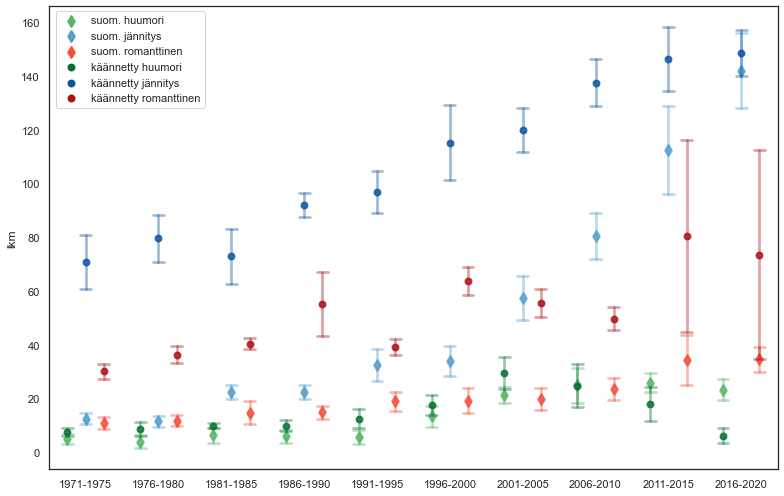

In [31]:
# plot I want to do in the end

fig,ax=plt.subplots(1, 1, figsize=(11,7))
combi_sub=fo_novel_author[fo_novel_author["year"]<2021]
combi_sub_fi=fi_novel[fi_novel["year"]<2021]

sns.pointplot('period', 'novel', hue='genre', alpha=0.7,
    data=combi_sub_fi, dodge=0.5, join=False, ci='sd', markers="d",palette=my_palette_2,ax=ax, capsize=0.15,scale = 1.1)


p=sns.pointplot('period2', 'novel', hue='genre', alpha=0.7,
    data=combi_sub, dodge=0.5, join=False, ci='sd', markers="o",palette=my_palette, ax=ax, capsize=0.15, scale = 0.9)

plt.setp(p.lines, alpha=.4) 
  

ax.get_legend().remove()
# add legend
handles, labels = ax.get_legend_handles_labels()
new_labels=["suom. huumori","suom. jännitys","suom. romanttinen","käännetty huumori", "käännetty jännitys", "käännetty romanttinen"]
fig.legend(handles[:6], new_labels, bbox_to_anchor=(0.27, 0.98))#, loc='upper left', ncol=1, bbox_to_anchor=(1, 0.98))
ax.set_xticklabels(labels=ax.get_xticklabels(), ha="center")

ax.set(xlabel='', ylabel='lkm')
fig.tight_layout()
plt.setp(p.collections, alpha=.8) 
#fig.savefig("../../output/figures/genre_5year_meansd.png")

In [32]:
# why is there such a SD in last romance publications
# a peak in 2015 and 2016
combi_sub[combi_sub["genre"]=="rakkaus"].tail(10)

,year,genre,novel,author,period,period2
122,2011,rakkaus,68,58,2011,2011-2015
125,2012,rakkaus,59,59,2011,2011-2015
128,2013,rakkaus,46,41,2011,2011-2015
131,2014,rakkaus,82,70,2011,2011-2015
134,2015,rakkaus,148,102,2011,2011-2015
137,2016,rakkaus,144,101,2016,2016-2020
140,2017,rakkaus,83,63,2016,2016-2020
143,2018,rakkaus,61,45,2016,2016-2020
146,2019,rakkaus,34,32,2016,2016-2020
149,2020,rakkaus,46,46,2016,2016-2020


In [33]:
genre_dict["rakkaus"]

['http://www.yso.fi/onto/koko/p12568',
 'http://www.yso.fi/onto/koko/p12857',
 'http://www.yso.fi/onto/koko/p50075',
 'http://www.yso.fi/onto/koko/p10465']

In [36]:
rom=df_fo[(df_fo["genre"]=="rakkaus")]
print(rom[rom["decade"]==2010].novel.nunique())
#rom[rom["decade"]==2010]#["novel"]

771


In [37]:
# query labels:

name_query = """

SELECT ?novel ?title 
WHERE

{

VALUES ?novel  {  MY_VALUES }

?novel skos:prefLabel ?title . FILTER (LANG(?title)="fi")

}

"""

n=0
novel_list=[]
substring=""
for a_novel in rom[rom["decade"]==2010]["novel"].unique():
    
    if n < 200:
        teos = " <"+a_novel+">"
        substring +=teos
        n+=1
        
    else:
        print("a sublist")
        teos = " <"+a_novel+">"
        substring +=teos
        novel_list.append(substring)
        substring=""
        n=0

novel_list.append(substring)

a sublist
a sublist
a sublist


In [38]:
# query titles for these books to see that they really are novels 
len(novel_list)
rom_novels=pd.DataFrame()
for nl in novel_list:
    sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
    q=name_query.replace("MY_VALUES", nl)
    sparql.setQuery(PREFIXES + q)
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
    results = sparql.query().convert()
    temp = JSON2Pandas2(results)
    rom_novels=pd.concat([rom_novels, temp])

In [39]:

rom_novels=rom_novels.merge(df_fo[["year","novel"]], how="left")


In [40]:
rom_novels.groupby("year")["novel"].nunique()

year
1976      1
1981      2
1983      1
2011     68
2012     59
2013     46
2014     82
2015    148
2016    144
2017     83
2018     61
2019     34
2020     46
2021      8
2022      5
Name: novel, dtype: int64

In [ ]:
rom_novels[rom_novels["year"].isin([2015,2016])].sample(50)
#rom_novels.sample(50)

## Statistics about development per decade

In [ ]:
# 
fo_sum=fo_novel_author.merge(fo_total, on="year", suffixes=["","_total"])
fi_sum=fi_novel.merge(fi_total, on="year", suffixes=["","_total"])
print(len(fi_sum))
fi_sum#.head()

In [ ]:
fi_total

In [ ]:
# genre novels per decade
fi_genre=df_fi.groupby(["decade"])[["novel"]].nunique().reset_index() # df_fi only contains genre
fo_genre=df_fo.groupby(["decade"])[["novel"]].nunique().reset_index()# df_fo only contains genre
fo_genre # genre sum per decade

In [ ]:
fo_new=fo_genre.merge(dec_df, on="decade", suffixes=["_genre",""])
fi_new=fi_genre.merge(dec_df_fi, on="decade", suffixes=["_genre",""])
fi_new
#dfdf=fi_new.merge(fo_new, on=["decade","genre","period"], suffixes=["_fi",""])

In [ ]:
# add to this novel per genre
fi_genre_dec=df_fi.groupby(["decade","genre"])["novel"].nunique().reset_index()
fi_genre_dec
fo_genre_dec=df_fo.groupby(["decade","genre"])["novel"].nunique().reset_index()
fo_genre_dec

In [ ]:
fi_decs=fi_new.merge(fi_genre_dec, on=["decade"], suffixes=["_total",""])
fo_decs=fo_new.merge(fo_genre_dec, on=["decade"], suffixes=["_total",""])

In [ ]:
genre_table=fo_decs.merge(fi_decs, on=["decade","genre"], suffixes=["","_fi"])

In [ ]:
genre_table["rel_fi"]=genre_table["novel_fi"]/genre_table["novel_total_fi"]
genre_table["rel"]=genre_table["novel"]/genre_table["novel_total"]
genre_table.columns

In [ ]:
print(genre_table[['decade', 'genre', 'novel', 'rel','novel_genre', 'novel_total', 'novel_fi', 'rel_fi', 
       'novel_genre_fi', 'novel_total_fi']].to_latex(index=False))
genre_table[['decade', 'genre', 'novel', 'rel','novel_genre', 'novel_total', 'novel_fi', 'rel_fi', 
       'novel_genre_fi', 'novel_total_fi']]

In [ ]:
genre_table2=genre_table
#genre_table2["FIxed"]= 
FIxed=genre_table2["novel_fi"].astype(str)+"("+round(genre_table2["rel_fi"],2).astype(str)+")"
FInnished=genre_table2["novel"].astype(str)+"("+round(genre_table2["rel"],2).astype(str)+")"
FI_total=genre_table2["novel_genre_fi"].astype(str)+" / "+genre_table2["novel_total_fi"].astype(str)
TR_total=genre_table2["novel_genre"].astype(str)+" / "+genre_table2["novel_total"].astype(str)

In [ ]:
genre_table2["FI"]=FIxed
genre_table2["TR"]=FInnished
genre_table2["FI_total"]=FI_total
genre_table2["TR_total"]=TR_total

In [ ]:
print(genre_table2[['decade', 'genre', 'FI', 'FI_total', 'TR', 'TR_total']].to_latex(index=False))

# t-testi

In [ ]:
# 1990-luvun KA VS 2010-luvun KA
fi_genre_year=df_fi.groupby(["year"])["novel"].nunique().reset_index()
fi_genre_year
fo_genre_year=df_fo.groupby(["year"])["novel"].nunique().reset_index()
fo_genre_year

In [ ]:
fo_year=fo_total.merge(fo_genre_year, on="year", suffixes=["_total","_genre"])
fi_year=fi_total.merge(fi_genre_year, on="year", suffixes=["_total","_genre"])

In [ ]:
fi_year["rel"]=fi_year["novel_genre"]/fi_year["novel_total"]
fi_year=add_decade(fi_year)
fi_year.head()

In [ ]:
fo_year["rel"]=fo_year["novel_genre"]/fo_year["novel_total"]
fo_year=add_decade(fo_year)
fo_year.head()

In [ ]:
import statsmodels.api as sm
from scipy import stats
import pandas
from scipy.stats import ttest_1samp,ttest_ind
# summary t-test, Finnish

# IT IS SIGNIFICANT ==> CHANGE

# t-test
testdf=fi_year
mean90 = testdf[testdf['decade'] == 1990]['rel']
mean2010 = testdf[testdf['decade'] == 2010]['rel']
print(np.mean(mean90), np.mean(mean2010))
print(ttest_ind(mean90, mean2010)  )


import researchpy as rp
rp.ttest(group1= mean90, group1_name= "90",
         group2= mean2010, group2_name= "10")

In [ ]:
sampling_difference = mean90.values - \
                      mean2010.values

# not significant, normally distributed
print(stats.shapiro(sampling_difference))
print(stats.shapiro(mean90.values))
print(stats.shapiro(mean2010.values))

fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()



In [ ]:
stats.levene(mean90.values,
             mean2010.values)

In [ ]:
testdf=fo_year
mean90 = testdf[testdf['decade'] == 1990]['rel']
mean2010 = testdf[testdf['decade'] == 2010]['rel']
print(np.mean(mean90), np.mean(mean2010))
print(ttest_ind(mean90, mean2010)  )


import researchpy as rp
rp.ttest(group1= mean90, group1_name= "90",
         group2= mean2010, group2_name= "10")

In [ ]:
sampling_difference = mean90.values - \
                      mean2010.values

# not significant, normally distributed
stats.shapiro(sampling_difference)

In [ ]:
fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()



In [ ]:
stats.levene(mean90.values,
             mean2010.values,
             center= 'mean')

## stats pohj. jännitys

In [ ]:
noir=df_fo.groupby(["genre","year","lang"])["novel"].nunique()
nordics=["http://lexvo.org/id/iso639-3/dan","http://lexvo.org/id/iso639-3/nor","http://lexvo.org/id/iso639-3/swe","http://lexvo.org/id/iso639-3/isl"]
nordic_crime_year=df_fo[(df_fo["genre"]=="jannitys")& (df_fo["lang"].isin(nordics))].groupby(["year"])["novel"].nunique().reset_index()
total_year_crime=df_fo[(df_fo["genre"]=="jannitys")].groupby(["year"])["novel"].nunique().reset_index()
df_crime=nordic_crime_year.merge(total_year_crime, on="year", suffixes=["_nordic",""])
df_crime["rel"]=df_crime["novel_nordic"]/df_crime["novel"]
df_crime=add_decade(df_crime)

In [ ]:
testdf=df_crime
mean90 = testdf[testdf['decade'] == 1990]['rel']
mean2010 = testdf[testdf['decade'] == 2010]['rel']
print(np.mean(mean90), np.mean(mean2010))
print(ttest_ind(mean90, mean2010)  )


import researchpy as rp
rp.ttest(group1= mean90, group1_name= "90",
         group2= mean2010, group2_name= "10")

In [ ]:
sampling_difference = mean90.values - \
                      mean2010.values

# not significant, normally distributed
stats.shapiro(sampling_difference)

In [ ]:
fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()

In [ ]:
stats.levene(mean90.values,
             mean2010.values
            )

In [ ]:
# do welch's?? or remove?

# plotting more plotting

In [ ]:
# add authors to df_fi
df_fi=df_fi[df_fi["decade"]!=2020]
print(len(novel_df_fi), len(df_fi), df_fi.nunique())
df_fi2=novel_df_fi.merge(df_fi, on=["novel","year","decade"], how="left")
df_fi2.nunique()

In [ ]:
# add authors to df_fo
df_fo=df_fo[df_fo["decade"]!=2020]
print(len(novel_df), len(df_fo), df_fo.nunique())
df_fo2=novel_df.merge(df_fo, on=["novel","year","decade","author"], how="left")
df_fo2.nunique()

In [ ]:
df_fo2.head()

In [ ]:
print(len(df_fi2),len(df_fi2[["novel","year","genre"]].drop_duplicates()),len(df_fi2[["novel","year"]].drop_duplicates()))#["author"].isna().unique()

In [ ]:
df_fo2=add_decade(df_fo2)
fo_genre_gender_dec=df_fo2.groupby(["decade","genre","gender_x"])["novel"].nunique().reset_index()

fo_gender_dec=df_fo2.groupby(["decade","gender_x"])["novel"].nunique().reset_index()
fo_gender_dec

fo_genre_dec=df_fo2.groupby(["decade","genre"])["novel"].nunique().reset_index()

fo_dec=df_fo2.groupby(["decade"])["novel"].nunique().reset_index()
fo_gender_dec

In [ ]:
df_fi2=add_decade(df_fi2)
fi_genre_gender_dec=df_fi2.groupby(["decade","genre","gender"])["novel"].nunique().reset_index()

fi_gender_dec=df_fi2.groupby(["decade","gender"])["novel"].nunique().reset_index()
fi_gender_dec

fi_genre_dec=df_fi2.groupby(["decade","genre"])["novel"].nunique().reset_index()

fi_dec=df_fi2.groupby(["decade"])["novel"].nunique().reset_index()
fi_genre_gender_dec

In [ ]:
# get gender per genre
all_fo=fo_genre_gender_dec.merge(fo_genre_dec, on=["decade","genre"], suffixes=["_gender","_genre"])
all_fo.merge(fo_gender_dec).merge(fo_dec, on="decade",suffixes=["_gender","_total"])

In [ ]:
all_fi=fi_genre_gender_dec.merge(fi_genre_dec, on=["decade","genre"], suffixes=["_genregender","_genre"]).merge(fi_dec).merge(fi_gender_dec, on=["decade","gender"], suffixes=["_total","_gender"])

In [ ]:
#print(6*5)
all_fi[all_fi["gender"]!="unk"]

In [ ]:

#all_fi.to_csv("././data/all_fi.csv",sep="/t")
#all_fo.to_csv("././data/all_fo.csv",sep="/t")


In [ ]:
#df_fo["lang"]
df_fo[df_fo["genre"]=="huumori"].head(20)

In [ ]:
# 4-plot

#df_fo

genre_info =pd.DataFrame()
for a_genre in ["jannitys","rakkaus","huumori"]:
    # gender per year
    temp=df_fo[df_fo["genre"]==a_genre]
    yearly_count=temp.groupby(["year","genre"])[["novel","author"]].nunique().reset_index()
    gender_count=temp.groupby(["year","genre","gender"])[["novel","author"]].nunique().reset_index()
    #lang_count=temp.groupby(["year","genre","gender"])[["lang"]].nunique().reset_index()
    #nat_count=temp.groupby(["year","genre","gender"])[["nat"]].nunique().reset_index()
    lang_count=temp.groupby(["year","genre"])[["lang"]].nunique().reset_index()
    nat_count=temp.groupby(["year","genre"])[["nat"]].nunique().reset_index()
    eng_share=df_fo[df_fo["lang"].isin(["http://lexvo.org/id/iso639-3/eng"])].groupby(["year","genre"])["novel"].nunique()
    nordic_share=df_fo[df_fo["lang"].isin(["http://lexvo.org/id/iso639-3/dan","http://lexvo.org/id/iso639-3/nor","http://lexvo.org/id/iso639-3/swe","http://lexvo.org/id/iso639-3/isl"])].groupby(["year","genre"])["novel"].nunique()
    new=yearly_count.merge(gender_count, on=["year","genre"],suffixes=["","_gender"])
    new=new.merge(lang_count,on=["year","genre"],suffixes=["","_lang"], how="left")
    new=new.merge(nat_count,on=["year","genre"],suffixes=["","_nat"], how="left")
    new=new.merge(eng_share,on=["year","genre"],suffixes=["","_eng"], how="left")
    new=new.merge(nordic_share,on=["year","genre"],suffixes=["","_nordic"], how="left")

    genre_info=pd.concat([genre_info, new])
    
genre_info.sort_values(by="year").head(15)

In [ ]:
genre_info_fi =pd.DataFrame()
for a_genre in ["jannitys","rakkaus","huumori"]:
    # gender per year
    temp=df_fi2[df_fi2["genre"]==a_genre]
    yearly_count=temp.groupby(["year","genre"])[["novel","author"]].nunique().reset_index()
    gender_count=temp.groupby(["year","genre","gender"])[["novel","author"]].nunique().reset_index()
    
    new=yearly_count.merge(gender_count, on=["year","genre"],suffixes=["","_gender"])
    #new=new.merge(lang_count,on=["year","genre"],suffixes=["","_lang"], how="left")
    #new=new.merge(nat_count,on=["year","genre"],suffixes=["","_nat"], how="left")
    #new=new.merge(eng_share,on=["year","genre"],suffixes=["","_eng"], how="left")
    #new=new.merge(nordic_share,on=["year","genre"],suffixes=["","_nordic"], how="left")

    genre_info_fi=pd.concat([genre_info_fi, new])
    
genre_info_fi.sort_values(by="year").head(15)

In [ ]:
genre_info["eng_share"]=genre_info["novel_eng"]/genre_info["novel"]
genre_info["nordic_share"]=genre_info["novel_nordic"]/genre_info["novel"]

In [ ]:
def add_period(df_fo, columnname="year"):
    df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
    df_fo['period'] = df_fo['period'].astype("str")

    df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return df_fo

genre_info=add_period(genre_info)

In [ ]:
genre_info_fi=add_period(genre_info_fi)

In [ ]:
genre_info.head()

In [ ]:
#len(year_df)

In [ ]:
# add gender_ratio
gender_rel=[]
for a_year in genre_info.year.unique():
    year_df_all=genre_info[genre_info["year"]==a_year]
    # get total count and male count
    for a_genre in ["jannitys","rakkaus","huumori"]:
        year_df=year_df_all[year_df_all["genre"]==a_genre]
        if len(year_df)> 0:
            total= year_df["novel"].iloc[0]
            if "http://www.yso.fi/onto/kaunokki#male" in year_df.gender.values :
                male = year_df[year_df["gender"]=="http://www.yso.fi/onto/kaunokki#male"]["novel_gender"].iloc[0]
            else:
                male = 0
            rel=male/total
            gender_rel.append({"year":a_year, "rel":rel, "genre":a_genre})
        else:
            print(whoops, a_year, a_genre)
            gender_rel.append({"year":a_year, "rel":0, "genre":a_genre})

In [ ]:
genre_info=genre_info.merge(pd.DataFrame(gender_rel))
# df_fo2[df_fo2["lang"].isin(["http://lexvo.org/id/iso639-3/dan","http://lexvo.org/id/iso639-3/nor","http://lexvo.org/id/iso639-3/swe","http://lexvo.org/id/iso639-3/isl"])].groupby(["period","genre","gender"])["novel"].nunique()

In [ ]:
gender_rel_fi=[]
for a_year in genre_info_fi.year.unique():
    year_df_all=genre_info_fi[genre_info_fi["year"]==a_year]
    # get total count and male count
    for a_genre in ["jannitys","rakkaus","huumori"]:
        year_df=year_df_all[year_df_all["genre"]==a_genre]
        if len(year_df)> 0:
            total= year_df["novel"].iloc[0]
            if "http://www.yso.fi/onto/kaunokki#male" in year_df.gender.values :
                male = year_df[year_df["gender"]=="http://www.yso.fi/onto/kaunokki#male"]["novel_gender"].iloc[0]
            else:
                male = 0
            rel=male/total
            gender_rel_fi.append({"year":a_year, "rel":rel, "genre":a_genre})
        else:
            print(whoops, a_year, a_genre)
            gender_rel_fi.append({"year":a_year, "rel":0, "genre":a_genre})

In [ ]:
genre_info_fi=genre_info_fi.merge(pd.DataFrame(gender_rel_fi))


In [ ]:
genre_info[genre_info["genre"]=="huumori"]

In [ ]:
genre_info["rel"]=1-genre_info["rel"]
genre_info_fi["rel"]=1-genre_info_fi["rel"]

In [ ]:
genre_info["nordic_share"].fillna(0,inplace=True)

In [ ]:
genre_info["eng_share"].fillna(0,inplace=True)

In [ ]:
# finnish against translations
genre_period_fi=genre_info_fi.groupby(["period","genre"])["novel"].nunique().reset_index()#/(genre_info_fi.groupby(["period","genre"])["novel"].nunique().values+genre_info.groupby(["period","genre"])["novel"].nunique().values)
genre_period_fo=genre_info.groupby(["period","genre"])["novel"].nunique().reset_index()#/(genre_info_fi.groupby(["period","genre"])["novel"].nunique().values+genre_info.groupby(["period","genre"])["novel"].nunique().values)
#genre_period_fo.merge_genre_perio
all_genre_info=genre_info_fi.merge(genre_info, on=["year","genre","period","gender"], suffixes=["_fi",""])
all_genre_info["fi_tr"]=all_genre_info["novel_fi"]/(all_genre_info["novel_fi"]+all_genre_info["novel"])

In [ ]:
all_genre_info.head(10)

In [ ]:
# simpson's diversity
def simpson_slice(df_slice):
  
  return df_slice**2 #.sum()

a_df=df_fo.drop_duplicates(["year","genre","novel"]).groupby(["lang","year","genre"])["novel"].nunique().reset_index()
#fo_total=df_fo.drop_duplicates(["year","genre","novel"]).groupby(["lang","year","genre"])["novel"].nunique().reset_index()
#[df_dec_genre_lang["genre"]==genre]
genre_year=df_fo.drop_duplicates(["year","genre","novel"]).groupby(["year","genre"])["novel"].nunique().reset_index()
genre_year

In [ ]:
a_df=a_df.merge(genre_year, on=["year","genre"], suffixes=["","_total"])
a_df

In [ ]:
a_df["rel"]=a_df["novel"]/a_df["novel_total"]
simpson_df=a_df.groupby(["year","lang","genre"]).rel.agg(simpson_slice).reset_index(name="simpson")
simpson=simpson_df.groupby(["year","genre"]).simpson.sum().apply(lambda x: 1-x).reset_index()
simpson["s_1"]=simpson.groupby(["year","genre"]).simpson.sum().values
#simpson
#simpson_df
#simpson["period"]=pd.to_numeric(simpson["year"])
    
simpson=add_period(simpson)
simpson

In [ ]:

# palette
pal_pub=sns.color_palette("Purples_r",5)
pal_nordic=sns.color_palette("Blues_r",5)
pal_fitr=sns.color_palette("coolwarm",10)
pal_lang=sns.color_palette("Oranges_r",5)
pal_nat=sns.color_palette("Greens_r",5)
pal_trfi=sns.color_palette("magma",10)
colormap=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_pub)}
colormap2=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_nordic)}
colormap_fitr=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_fitr[:5])}
colormap_trfi=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_trfi[2:8])}
colormap3=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_lang)}
colormap4=  { p:m for p,m in zip (list(simpson.genre.unique()), pal_nat)}
pal_fitr


In [ ]:
genre_info.head()

In [ ]:
fig,ax=plt.subplots(2,2, figsize=(12,10))

line_style={"rakkaus":"--","jannitys":"-","huumori":"-."}
# suom -- käännös suhde
for genre in genre_info_fi.genre.unique():
    temp=all_genre_info[(all_genre_info["genre"]==genre)].drop_duplicates(["genre","year"])
    feature="fi_tr"
    mean_2=temp.groupby("period")[feature].mean().reset_index()  
    mean_shade=temp.groupby("period")[feature].mean()
    std_2=temp.groupby("period")[feature].std()#.reset_index()  
    temp_size=temp.groupby("period")["novel"].sum().reset_index()  
    temp_df=temp_size.merge(mean_2)
    years=list(mean_shade.index)
    max_size=temp_size["novel"].max()

    #print(len(temp_size),len(years), len(mean_2))
    #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][1], color=pal_feat[feature])
    p=sns.lineplot(x="period", y=feature,  ax=ax[1][0], data=temp_df,color="black", linestyle=line_style[genre], label=genre)#,linestyle=line_style[feature])
    ax[1][0].set(title='Suomenkielisen ja käännöskirjallisuuden\njulkaisumäärän suhde')
    #ax[1][0].legend([], frameon=False)
    ax[1][0].set(ylim=(-0.1, 1.1))#, xlim=(1969,20))
    ax[1][0].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap_fitr[genre], alpha=0.2)
    ax[1][0].set(xlabel='', ylabel='')
#p.legend(bbox_to_anchor=(-1.05, 1), loc='upper left')
m,n=p.get_legend_handles_labels()
print(n)
n=["jännitys", "romanttinen","huumori"]
fig.legend(labels=n, handles=m)


In [ ]:
fig,ax=plt.subplots(2,2, figsize=(12,10))



SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


pal_nordic=sns.color_palette("Blues")
pal_eng=sns.color_palette("PuOr")
pal_s=sns.color_palette("Greens")
pal_genre={"jannitys":pal_nordic[4], "rakkaus":pal_eng[5],"huumori":pal_s[4]}
pal_genre2={"jannitys":pal_nordic[2], "rakkaus":pal_eng[4],"huumori":pal_s[2]}

pal_feat={"nordic_share":pal_nordic[2],"eng_share":pal_eng[5]}
line_style={"nat":"--","lang":"-"}
line_style={"rakkaus":"--","jannitys":"-","huumori":"-."}
line_lang={"eng_share":"-", "nordic_share":"-"}
markers={"nat":"d","lang":"o", "eng_share":"d","nordic_share":"s"}
for genre in genre_info.genre.unique():
    temp=genre_info[(genre_info["genre"]==genre)].drop_duplicates(["genre","year"])
    for feature in ["nat"]:
        mean_2=temp.groupby("period")[feature].mean().reset_index()  
        mean_shade=temp.groupby("period")[feature].mean()
        std_2=temp.groupby("period")[feature].std()#.reset_index()  
        temp_size=temp.groupby("period")["novel"].sum().reset_index()  
        temp_df=temp_size.merge(mean_2)
        years=list(mean_shade.index)
        max_size=temp_size["novel"].max()

        #print(len(temp_size),len(years), len(mean_2))
        #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][0], color=pal_genre[genre])
        
        sns.lineplot(x="period", y=feature,  ax=ax[0][0], data=temp_df,color=colormap4[genre],linestyle=line_style[genre])
       #ax[0][0].set(title='Kielien lukumäärä genreä kohden')
        ax[0][0].legend([], frameon=False)
        ax[0][0].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap4[genre], alpha=0.1)
        ax[0][0].set(xlabel='', ylabel='')
        
    for feature in ["lang"]:
        mean_2=temp.groupby("period")[feature].mean().reset_index()  
        mean_shade=temp.groupby("period")[feature].mean()
        std_2=temp.groupby("period")[feature].std()#.reset_index()  
        temp_size=temp.groupby("period")["novel"].sum().reset_index()  
        temp_df=temp_size.merge(mean_2)
        years=list(mean_shade.index)
        max_size=temp_size["novel"].max()

        #print(len(temp_size),len(years), len(mean_2))
        #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][0], color=pal_genre[genre])
        
        sns.lineplot(x="period", y=feature,  ax=ax[0][0], data=temp_df,color=colormap3[genre],linestyle=line_style[genre])
        ax[0][0].set(title='a) Kielien (oranssi) ja kansalaisuuksien (vihr.)\nlukumäärä genreä kohden')
        ax[0][0].legend([], frameon=False)
        ax[0][0].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap3[genre], alpha=0.1)
        ax[0][0].set(xlabel='', ylabel='')
        ax[0][0].locator_params(axis="y", integer=True, tight=False)
for genre in genre_info.genre.unique():
    temp=genre_info[(genre_info["genre"]==genre)].drop_duplicates(["genre","year"])
    #print()
    for feature in ["eng_share","nordic_share"]:
    #feature="eng_share"
        mean_2=temp.groupby("period")[feature].mean().reset_index()  
        mean_shade=temp.groupby("period")[feature].mean()
        std_2=temp.groupby("period")[feature].std()#.reset_index()  
        temp_size=temp.groupby("period")["novel"].sum().reset_index()  
        temp_df=temp_size.merge(mean_2)
        years=list(mean_shade.index)
        max_size=temp_size["novel"].max()

        #print(len(temp_size),len(years), len(mean_2))
        #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][1], color=pal_feat[feature])
        if feature =="eng_share":
            sns.lineplot(x="period", y=feature,  ax=ax[0][1], data=temp_df,color=colormap[genre], linestyle=line_style[genre])#,linestyle=line_style[feature])
            ax[0][1].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap[genre], alpha=0.2)
        else:
            sns.lineplot(x="period", y=feature,  ax=ax[0][1], data=temp_df,color=colormap2[genre], linestyle=line_style[genre])
            ax[0][1].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap2[genre], alpha=0.2)
        ax[0][1].set(title='b) Englannin (viol.) ja pohjoismaisten kielien (sin) osuus\nkäännöskirjallisuudesta')
        ax[0][1].legend([], frameon=False)
        ax[0][1].set(ylim=(-0.1, 1.1))#, xlim=(1969,2020))
        ax[0][1].set(xlabel='', ylabel='')
        
        
for genre in genre_info.genre.unique():
    temp=genre_info[(genre_info["genre"]==genre)].drop_duplicates(["genre","year"])
    #print()
    for feature in ["rel"]:
    #feature="eng_share"
        mean_2=temp.groupby("period")[feature].mean().reset_index()  
        mean_shade=temp.groupby("period")[feature].mean()
        std_2=temp.groupby("period")[feature].std()#.reset_index()  
        temp_size=temp.groupby("period")["novel"].sum().reset_index()  
        temp_df=temp_size.merge(mean_2)
        years=list(mean_shade.index)
        max_size=temp_size["novel"].max()

        #print(len(temp_size),len(years), len(mean_2))
        #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][1], color=pal_feat[feature])
        sns.lineplot(x="period", y=feature,  ax=ax[1][1], data=temp_df,color=colormap_trfi[genre], linestyle=line_style[genre])#,linestyle=line_style[feature])
        ax[1][1].set(title='Gender share')
        ax[1][1].legend([], frameon=False)
        ax[1][1].set(ylim=(-0.1, 1.1))
        ax[1][1].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap_trfi[genre], alpha=0.1)
        ax[1][1].set(xlabel='', ylabel='')
        
# suom sukupuolijakauma
for genre in genre_info_fi.genre.unique():
    temp=genre_info_fi[(genre_info_fi["genre"]==genre)].drop_duplicates(["genre","year"])
    #print()
    for feature in ["rel"]:
    #feature="eng_share"
        mean_2=temp.groupby("period")[feature].mean().reset_index()  
        mean_shade=temp.groupby("period")[feature].mean()
        std_2=temp.groupby("period")[feature].std()#.reset_index()  
        temp_size=temp.groupby("period")["novel"].sum().reset_index()  
        temp_df=temp_size.merge(mean_2)
        years=list(mean_shade.index)
        max_size=temp_size["novel"].max()

        #print(len(temp_size),len(years), len(mean_2))
        #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][1], color=pal_feat[feature])
        sns.lineplot(x="period", y=feature,  ax=ax[1][1], data=temp_df,color=colormap_fitr[genre], linestyle=line_style[genre])#,linestyle=line_style[feature])
        ax[1][1].set(title='d) Naiskirjailijoiden osuus suomenkielisissä (sin.)\nja käännetyissä (lila) romaaneissa')
        ax[1][1].legend([], frameon=False)
        ax[1][1].set(ylim=(-0.1, 1.1))
        ax[1][1].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap_fitr[genre], alpha=0.2)
        ax[1][1].set(xlabel='', ylabel='')
        
                
# suom -- käännös suhde
for genre in genre_info_fi.genre.unique():
    temp=all_genre_info[(all_genre_info["genre"]==genre)].drop_duplicates(["genre","year"])
    feature="fi_tr"
    mean_2=temp.groupby("period")[feature].mean().reset_index()  
    mean_shade=temp.groupby("period")[feature].mean()
    std_2=temp.groupby("period")[feature].std()#.reset_index()  
    temp_size=temp.groupby("period")["novel"].sum().reset_index()  
    temp_df=temp_size.merge(mean_2)
    years=list(mean_shade.index)
    max_size=temp_size["novel"].max()

    #print(len(temp_size),len(years), len(mean_2))
    #sns.scatterplot(x="period", y=feature, marker=markers[feature], size="novel", data=temp_df,sizes=(8, max_size/4), ax=ax[0][1], color=pal_feat[feature])
    sns.lineplot(x="period", y=feature,  ax=ax[1][0], data=temp_df,color=colormap_fitr[genre], linestyle=line_style[genre])#,linestyle=line_style[feature])
    ax[1][0].set(title='c) Suomenkielisten julkaisujen osuus kaikista julkaisuista')
    ax[1][0].legend([], frameon=False)
    ax[1][0].set(ylim=(-0.1, 1.1))#, xlim=(1969,20))
    ax[1][0].fill_between(years, mean_shade - std_2, mean_shade + std_2, color=colormap_fitr[genre], alpha=0.2)
    ax[1][0].set(xlabel='', ylabel='')
#for an_ax in list(ax):
#    an_ax.set(xlabel='', ylabel='')

legend=fig.legend(labels=n, handles=m, loc="lower center", ncol=3,  bbox_to_anchor=(0.5, -0.035))
fig.tight_layout()
#fig.savefig("../../output/genre_plots4_new.png",bbox_extra_artists=(legend,), bbox_inches='tight')